In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from abc import ABC,abstractclassmethod, abstractstaticmethod

from prml.utils.encoder import OnehotToLabel
from prml.linear_regression import LinearRegression

# Auto Regressive Model

In [2]:
class AR():
    """AR

    auto regressive model 

    """
    def __init__(self,p) -> None:
        """

        Args:
            p (int): number of past data used to predict next variables 

        """
        self.p = p
    
    def _make_data(self,X):
        N = X.shape[0] - self.p 
        data = np.zeros((N,self.p))
        for i in range(N):
            data[i] = X[i:i+self.p]
        return data 

    def fit(self,X):
        """fit 

        Args:
            X (1-D array): sequential data

        """

        y = X[self.p:] 
        X = self._make_data(X)
        model = LinearRegression(basis_function="polynomial",deg=1)
        model.fit(X,y.reshape(-1,1))
        self.model = model 
    
    def predict(self,X,size=1):
        """predict

        Args:
            X (1-D array): sequential data 
            size (int): number of predict data from the lasta data of X 
        
        Returns:
            pred (1-D array): shape = (size), predicted variables 

        """
        X = X[-self.p:]
        pred = np.zeros(size)
        for i in range(size):
            y = self.model.predict(X.reshape(1,-1)).ravel()
            pred[i] = y[0]  
            X = np.concatenate((X[1:],y))
        
        return pred

In [3]:
def make_sequential_data(n=100,increase=True):
    t = np.linspace(0,20,n)
    if increase:
        trend = 0.8*t + np.random.randn(n)*0.2
    else:
        trend = np.random.randn(n)*0.2
    seasonal = np.sin(t*4000)*2
    return trend + seasonal

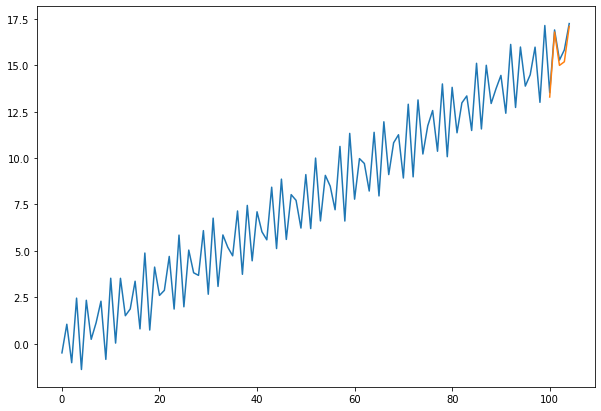

In [4]:
ar = AR(p = 5)
X = make_sequential_data(n=105)
X_tr,X_val = X[:100],X[100:]
ar.fit(X_tr)
X_pred = ar.predict(X_tr,size=5) 

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.arange(105),X,label = "data")
ax.plot(np.arange(100,105),X_pred,label = "predicted data")
plt.show()

In [5]:

class BaseHMM(ABC):
    """BaseHMM

    Attributes:

    """
    def __init__(self,K,max_iter=100,threshold=1e-5) -> None:
        """init

        Args:
            K (int): dimension of latent space
            max_iter (int): number of max iteration 
            threshold (float): threshold 

        """
        self.K = K 
        self.max_iter = max_iter 
        self.threshold = threshold
    
    def _Estep(self,X,pi,A,params):
        """_Estep 

        forward backward algotithum

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            pi (1-D array): pi[i]
            A (2-D array): A[j][k] = p(z_k=1|z_j=1)
            params (object): params 

        """

        N = X.shape[0] 
        pXZ = self._prob_cond(X,params)

        # alpha 
        alpha = np.zeros((N,self.K))
        alpha[0] = pi*pXZ[0]
        for i in range(N-1):
            alpha[i+1] = pXZ[i+1]*np.dot(A.T,alpha[i])

        # beta 
        beta = np.zeros((N,self.K)) 
        beta[N-1] = np.ones(self.K) 
        for i in range(N-2,-1,-1):
            beta[i] = np.dot(A,beta[i+1]*pXZ[i+1])

        likelihood = np.sum(alpha[-1])
        gamma = alpha*beta/likelihood
        xi = alpha[:-1].reshape(N-1,self.K,1)*pXZ[1:].reshape(N-1,1,self.K)*A*beta[1:].reshape(N-1,1,self.K)/likelihood
        return gamma,xi,likelihood

    def _Mstep(self,X,gamma,xi):
        """Mstep

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            gamma (2-D array): shape = (N,K), probablity of belonging to certain latent space
            xi (3-D array): shape = (N-1,K,K), transition probablity 

        """
        pi = gamma[0]/gamma[0].sum()
        A = xi.sum(axis = 0)/xi.sum(axis = (0,2)) 
        params = self._specializeMstep(X,gamma)
        return pi,A,params  
    
    def fit(self,X):
        """fit

        Args:
            X (2-D array): shape = (N,N_dim),time series data

        """

        N = X.shape[0] 
        gamma = np.random.rand(N,self.K)
        xi = np.random.rand(N-1,self.K,self.K)

        for _ in range(self.max_iter):
            pi,A,params = self._Mstep(X,gamma,xi)
            gamma_new,xi_new,likelihood = self._Estep(X,pi,A,params)

            if np.mean((gamma_new - gamma)**2)**0.5 + np.mean((xi_new - xi)**2)**0.5 < self.threshold:
                gamma = gamma_new
                xi = xi_new 
                break 

            gamma = gamma_new
            xi = xi_new 
        
        self.pi = pi 
        self.A = A 
        self.params = params 

    def predict(self,X,size=1):
        """predict

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            size (int): number of predict data from the lasta data of X 
        
        Returns:
            pred (2-D array): shape = (size,-1),predicted variables 

        """
        pred = np.zeros((size,X.shape[1]))
        gamma,_,_ = self._Estep(X,self.pi,self.A,self.params)
        z = gamma[-1]
        for i in range(size):
            z = np.dot(self.A.T,z)
            pred[i] = self._predict(z)
        return pred 
    
    @abstractclassmethod
    def _specializeMstep(self,X,gamma):
        """_specializeMstep 

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            gamma (2-D array): shape = (N,K), probablity of belonging to certain latent space
        
        Returns:
            params (object): optimized param 

        """
        pass 

    @abstractclassmethod
    def _prob_cond(self,X,params):
        """

        px[i] express p(X|z_k=1)

        Args:
            X (2-D array): shape = (N,N_dim)
            params (object): param 
        
        Returns:
            pX (2-D array): shape = (N,K),probablity of X

        """
        pass 

    @abstractclassmethod
    def _predict(self,z):
        """_predict 

        Args:
            z (1-D array): shape = (K),latent variables 

        Returns:
            Ex (1-D array): shape = (N_dim),expected value of X under the conditions of z
        """
        pass 


class GaussHMM(BaseHMM):
    """GaussHMM

    Attributes:

    """
    def __init__(self, K, max_iter=100, threshold=1e-5) -> None:
        super(GaussHMM,self).__init__(K, max_iter=max_iter, threshold=threshold)
    
    def _specializeMstep(self,X,gamma):
        """_specializeMstep 

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            gamma (2-D array): shape = (N,K), probablity of belonging to certain latent space 
        
        Returns:
            params (object): optimized param 

        """
        
        N = X.shape[0] 
        mu = gamma.T@X/gamma.sum(axis = 0).reshape(-1,1)
        tmp = X.reshape(N,1,-1) - mu.reshape(1,self.K,-1)
        sigma = np.sum(gamma.reshape(N,self.K,1,1)*tmp.reshape(N,self.K,-1,1)*tmp.reshape(N,self.K,1,-1),axis=0)/gamma.sum(axis=0).reshape(self.K,1,1)
        return {
            "mu":mu,
            "sigma":sigma,
            "sigma_inv":np.linalg.inv(sigma)
        }

    def _prob_cond(self,X,params):
        """

        px[i] express p(X|z_k=1)

        Args:
            X (2-D array): shape = (N,N_dim)
            params (object): param 
        
        Returns:
            pX (2-D array): shape = (N,K),probablity of X

        """
        norm_const = 1/((2*np.pi)**X.shape[1]*np.linalg.det(params["sigma"]))**0.5
        N_dim = X.shape[1]
        tmp = X.reshape(-1,1,N_dim) - params["mu"].reshape(1,self.K,N_dim)
        pX = norm_const*np.exp(-(tmp.reshape(-1,self.K,N_dim,1)@params["sigma_inv"]@tmp.reshape(-1,self.K,1,N_dim)).reshape(-1,self.K))
        return pX 

    def _predict(self,z):
        """_predict 

        Args:
            z (1-D array): shape = (K),latent variables 

        Returns:
            Ex (1-D array): shape = (N_dim),expected value of X under the conditions of z
        """
        return np.dot(self.params["mu"].T,z)

HMM can only predict stationary process

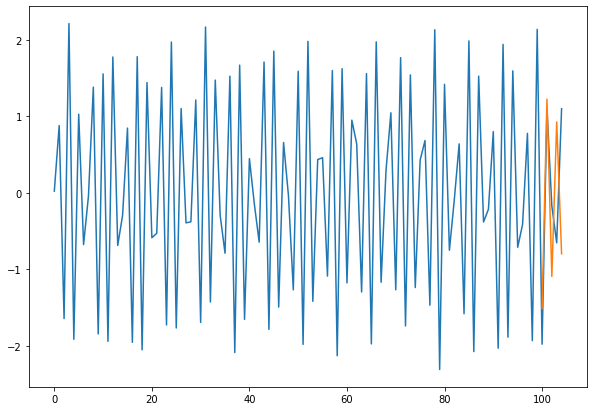

In [6]:
ghmm = GaussHMM(K=5)
X = make_sequential_data(n=105,increase=False)
X_tr,X_val = X[:100],X[100:]
ghmm.fit(X_tr.reshape(-1,1))
X_pred = ghmm.predict(X_tr.reshape(-1,1),size=5) 

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.arange(105),X,label = "data")
ax.plot(np.arange(100,105),X_pred,label = "predicted data")
plt.show()

# Bernoulli Hidden Markov Model 

In [7]:

class BernoulliHMM(BaseHMM):
    """BernoulliHMM

    Attributes:

    """
    def __init__(self, K, max_iter=100, threshold=1e-5) -> None:
        super().__init__(K, max_iter=max_iter, threshold=threshold)
    
    def _specializeMstep(self,X,gamma):
        """_specializeMstep 

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            gamma (2-D array): shape = (N,K), probablity of belonging to certain latent space
        
        Returns:
            params (object): optimized param 

        """
        mu = gamma.T@X/gamma.sum(axis = 0).reshape(-1,1)
        return {
            "mu":mu
        }

    def _prob_cond(self,X,params):
        """

        px[i] express p(X|z_k=1)

        Args:
            X (2-D array): shape = (N,N_dim)
            params (object): param 
        
        Returns:
            pX (2-D array): shape = (N,K),probablity of X

        """
        ohe = OnehotToLabel() 
        y = ohe.fit_transform(X).astype("int")
        return params["mu"][:,y].T

    def _predict(self,z):
        """_predict 

        Args:
            z (1-D array): shape = (K),latent variables 

        Returns:
            Ex (1-D array): shape = (N_dim),expected value of X under the conditions of z
        """
        return np.dot(self.params["mu"].T,z)

In [8]:
def make_markov_data(n=100):
    data = np.zeros((n,6)) 
    A = np.random.rand(6,6) + 10*np.eye(6) 
    A /= A.sum(axis = 0)

    state = np.random.multinomial(1,np.array([1/6]*6))
    data[0] = state 
    for i in range(n-1): 
        next = np.dot(A,state)
        state = np.random.multinomial(1,next) 
        data[i+1] = state
    
    return data

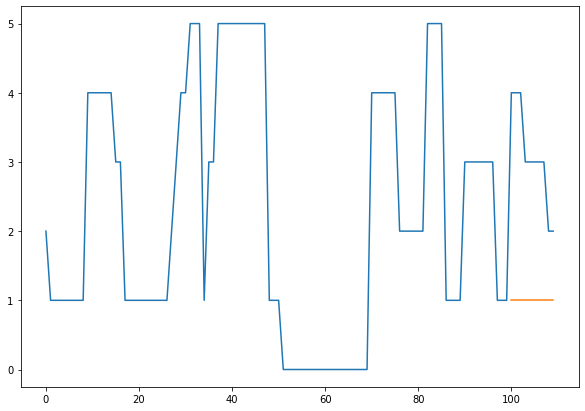

In [9]:
bhmm = BernoulliHMM(K=5)
X = make_markov_data(n=110)
X_tr,X_val = X[:100],X[100:]
bhmm.fit(X_tr) 
X_pred = bhmm.predict(X_tr,size=10).argmax(axis = 1)

ohe = OnehotToLabel()
X = ohe.fit_transform(X)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.arange(110),X,label = "data")
ax.plot(np.arange(100,110),X_pred,label = "predicted data")
plt.show()

# Linear Dynamic System

In [10]:
class LinearDynamicalSystem():
    """LinearDynamicalSystem

    Attributes:
        K (int): dimension of latent space
        A (2-D array): shape = (K,K), z_{n+1} = Az_n
        Gamma (2-D array): shape = (K,K) 
        C (2-D array): shape = (M,K)
        Sigma (2-D array): shape = (M,M)
        mu0 (1-D array): shape = (K) 
        P0 (2-D array): shape = (K,K)
        max_iter (int): number of max iteration 
        threshold (float): threshold
        
    """
    def __init__(self,K,max_iter=100,threshold=1e-5) -> None:
        """init

        Args:
            K (int): dimension of latent space
            max_iter (int): number of max iteration 
            threshold (float): threshold 

        """
        self.K = K 
        self.max_iter = max_iter
        self.threshold = threshold

    def _Estep(self,X,A,Gamma,C,Sigma,mu0,P0):
        """

        Args:
            X (2-D array): shape = (N,M) 
            A (2-D array): shape = (K,K), z_{n+1} = Az_n
            Gamma (2-D array): shape = (K,K) 
            C (2-D array): shape = (M,K)
            Sigma (2-D array): shape = (M,M)
            mu0 (1-D array): shape = (K) 
            P0 (2-D array): shape = (K,K)
        
        Returns:
            mu (2-D array): shape = (N,K) 
            V (3-D array): shape = (N,K,K) 
            J (3-D array): shape = (N,K,K)

        """

        N = X.shape[0] 
        mu = np.zeros((N,self.K)) 
        V = np.zeros((N,self.K,self.K))
        P = np.zeros((N,self.K,self.K))

        # forward 
        K = P0@C.T@np.linalg.inv(C@P0@C.T + Sigma)
        mu[0] = mu0 + np.dot(K,X[0] - np.dot(C,mu0))
        V[0] = (np.eye(self.K) - K@C)@P0 
        for i in range(N-1):
            P[i] = A@V[i]@A.T + Gamma 
            K = P[i]@C.T@np.linalg.inv(C@P[i]@C.T + Sigma) 
            mu[i+1] = np.dot(A,mu[i]) + np.dot(K,X[i+1] - np.dot(C@A,mu[i])) 
            V[i+1] = (np.eye(self.K) - K@C)@P[i]
        
        # backward 
        muhat = np.zeros((N,self.K)) 
        Vhat = np.zeros((N,self.K,self.K))
        J = np.zeros((N,self.K,self.K))
        muhat[-1] = mu[-1]
        Vhat[-1] = V[-1]
        for i in range(N-2,-1,-1):
            J[i] = V[i]@A.T@np.linalg.inv(P[i]) 
            muhat[i] = mu[i] + np.dot(J[i],muhat[i+1] - np.dot(A,mu[i])) 
            Vhat[i] = V[i] + J[i]@(Vhat[i+1] - P[i])@J[i].T 
        
        return muhat,Vhat,J 

    def _Mstep(self,X,mu,V,J):
        """

        Args:
            X (2-D array): shape = (N,M) 
            mu (2-D array): shape = (N,K) 
            V (3-D array): shape = (N,K,K) 
            J (3-D array): shape = (N,K,K)
        
        Returns:
            A (2-D array): shape = (K,K), z_{n+1} = Az_n
            Gamma (2-D array): shape = (K,K) 
            C (2-D array): shape = (M,K)
            Sigma (2-D array): shape = (M,M)
            mu0 (1-D array): shape = (K) 
            P0 (2-D array): shape = (K,K)

        """

        N = X.shape[0]
        E_z = mu 
        E_zz_d = V[1:]@J[:-1].transpose(0,2,1) + mu[1:].reshape(N-1,self.K,1)*mu[:-1].reshape(N-1,1,self.K) 
        E_zz = V + mu.reshape(N,self.K,1)*mu.reshape(N,1,self.K)
        
        mu0 = E_z[0] 
        P0 = E_zz[0] - E_z[0].reshape(-1,1)*E_z[0]

        A = np.sum(E_zz_d,axis=0)@np.linalg.inv(np.sum(E_zz[:-1],axis=0))
        Gamma = np.mean(E_zz[1:] - A@E_zz_d - E_zz_d@A.T + A@E_zz[:-1]@A.T,axis = 0)

        C = X.T@E_z@np.linalg.inv(np.sum(E_zz,axis=0))
        Sigma = (X.T@X - C@E_z.T@X - X.T@E_z@C.T + C@E_zz.sum(axis=0)@C.T)/N 

        return A,Gamma,C,Sigma,mu0,P0

    def fit(self,X):
        """fit

        Args:
            X (2-D array): shape = (N,N_dim),time series data

        """

        N = X.shape[0]
        M = X.shape[1]

        # random initialize 
        A = np.random.randn(self.K,self.K) 
        tmp = np.random.randn(self.K,3)
        Gamma = tmp@tmp.T 
        C = np.random.randn(X.shape[1],self.K) 
        tmp = np.random.randn(X.shape[1],3)
        Sigma = tmp@tmp.T
        mu0 = np.random.randn(self.K) 
        tmp = np.random.randn(self.K,3)
        P0 = tmp@tmp.T

        for _ in range(self.max_iter):
            mu,V,J = self._Estep(X,A,Gamma,C,Sigma,mu0,P0) 
            A_new,Gamma_new,C_new,Sigma_new,mu0_new,P0_new = self._Mstep(X,mu,V,J)
            
            diff = 0
            diff += np.mean((A_new - A)**2) 
            diff += np.mean((Gamma_new - Gamma)**2) 
            diff += np.mean((C_new - C)**2) 
            diff += np.mean((Sigma_new - Sigma)**2) 
            diff += np.mean((mu0_new - mu0)**2) 
            diff += np.mean((P0_new - P0)**2) 
            diff /= 6 

            A = A_new 
            Gamma = Gamma_new
            C = C_new 
            Sigma = Sigma_new
            mu0 = mu0_new
            P0 = P0_new

            if diff**0.5 < self.threshold: 
                break 
        
        self.A = A 
        self.Gamma = Gamma 
        self.C = C 
        self.Sigma = Sigma 
        self.mu0 = mu0 
        self.P0 = P0  

    def predict(self,X,size=1):
        """predict

        predict future movement 

        Args:
            X (2-D array): shape = (N,N_dim),time series data
            size (int): number of predict data from the lasta data of X 
        
        Returns:
            pred (2-D array): shape = (size,N_dim),predicted variables 

        """
        N = X.shape[0] 
        mu = np.zeros((N,self.K)) 
        V = np.zeros((N,self.K,self.K))
        P = np.zeros((N,self.K,self.K))

        # forward 
        K = self.P0@self.C.T@np.linalg.inv(self.C@self.P0@self.C.T + self.Sigma)
        mu[0] = self.mu0 + np.dot(K,X[0] - np.dot(self.C,self.mu0))
        V[0] = (np.eye(self.K) - K@self.C)@self.P0 
        for i in range(N-1):
            P[i] = self.A@V[i]@self.A.T + self.Gamma 
            K = P[i]@self.C.T@np.linalg.inv(self.C@P[i]@self.C.T + self.Sigma)
            mu[i+1] = np.dot(self.A,mu[i]) + np.dot(K,X[i+1] - np.dot(self.C@self.A,mu[i])) 
            V[i+1] = (np.eye(self.K) - K@self.C)@P[i] 
        
        X_pred = np.zeros((size,X.shape[1]))
        z = mu[-1]
        for i in range(size):
            z = np.dot(self.A,z) 
            X_pred[i] = np.dot(self.C,z)
        
        return X_pred 

In [11]:
def make_tracking_data(n=50):
    X = np.zeros((n,2))
    rad = 0
    for i in range(n-1):
        X[i+1] = X[i] + np.array([np.cos(rad),np.sin(rad)])*4
        rad += 0.20
    return X,X+np.random.randn(n,2)

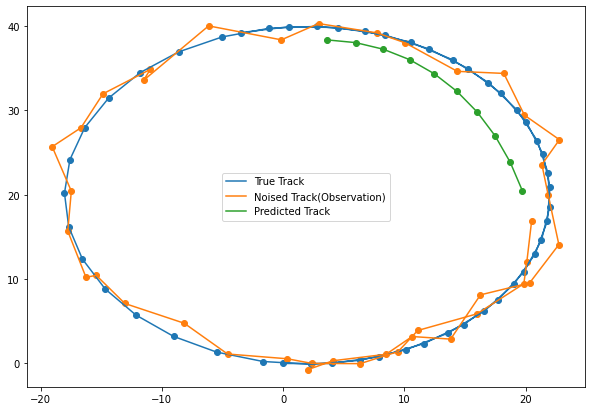

In [14]:
X_true,X_noised = make_tracking_data(n=50)
X_tr = X_noised[:40]

lds = LinearDynamicalSystem(K=4,max_iter=100)
lds.fit(X_tr) 
X_pred = lds.predict(X_tr,size=10)

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(X_true[:,0],X_true[:,1])
ax.plot(X_true[:,0],X_true[:,1],label = "True Track")
ax.scatter(X_tr[:,0],X_tr[:,1])
ax.plot(X_tr[:,0],X_tr[:,1],label = "Noised Track(Observation)")
ax.scatter(X_pred[:,0],X_pred[:,1])
ax.plot(X_pred[:,0],X_pred[:,1],label = "Predicted Track")
plt.legend()
plt.show()